<a href="https://colab.research.google.com/github/mikiya2014/My-projects/blob/main/Project2_Predict_Health_Outcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Description

There are three types of health-related data that are tracked (see “List of variable descriptions” for more info):


*   Health Outcomes (choose one for target variable)

        Arthritis, asthma, high blood pressure, high cholesterol, cancer, diabetes, kidney disease, pulmonary disease stroke, mental health not good for >14 days, physical health not good for >14 days, all teeth lost
*   Prevention (use all for modeling)
        Current lack of health insurance, visits to doctor within past year, visits to dentist, taking medicine for BP, cholesterol screening, mammography, pap smear, fecal occult blood test, up to date on preventative services for men (or women)


*   Unhealthy Behaviors (use all for modeling)
        Binge drinking, smoking, no leisure time physical activity, obesity, sleeping less than 7 hours

### Goal: Use the “Prevention” and “Unhealthy Behaviors” data to predict ONE of the “Health Outcomes

**Our target variable is Cancer_CrudePrev**

## Data Wrangling

In [ ]:
import numpy as np
from numpy import arange
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Column selection

In [ ]:
#https://drive.google.com/file/d/1S4HdSF7FdQlTE7bzqeXmowStGLJ9_qs3/view?usp=sharing
import pandas as pd
url = "https://drive.google.com/uc?export=download&id=1S4HdSF7FdQlTE7bzqeXmowStGLJ9_qs3" 

df_init = pd.read_csv(url, header = 0)
df_tem=df_init[['StateAbbr','PlaceName','PlaceFIPS','Population2010']]
select_cols = df_init.filter(regex='CrudePrev')
df=pd.concat([df_tem,select_cols],axis=1)
df.head()
#data has 500 rows

StateAbbr PlaceName  ...  STROKE_CrudePrev  TEETHLOST_CrudePrev
0        CA    Folsom  ...               1.9                  6.8
1        FL     Largo  ...               4.5                 18.3
2        CA  Berkeley  ...               1.9                  6.7
3        CA      Napa  ...               2.8                 11.2
4        FL   Sunrise  ...               3.7                 16.2

[5 rows x 32 columns]

### Missing data handling

In [ ]:
null_data = df[df.isnull().any(axis=1)]
len(null_data)#47
null_data_tem=null_data.drop(columns=['StateAbbr','PlaceName','PlaceFIPS'])
row_name=null_data[['StateAbbr','PlaceName','PlaceFIPS']]
df_tem2=df.drop(null_data.index)
#453 rows without missing data
df_tem2.head()
df2=df_tem2.drop(columns=['StateAbbr','PlaceName','PlaceFIPS'])
df2=df2.astype(float)
df_tem3=pd.concat([df_tem2[['StateAbbr','PlaceName','PlaceFIPS']],df2],axis=1)
mean_tem=pd.DataFrame(df_tem3.drop(columns=['PlaceName','PlaceFIPS']).mean()).transpose()
mean_tem=mean_tem.astype('str')
for col in null_data_tem.columns:
    null_data_tem.loc[:,col]=null_data_tem.loc[:,col].fillna(mean_tem.iloc[0][col])
null_data_tem=null_data_tem.astype('float')
new_null=pd.concat([null_data[['StateAbbr','PlaceName','PlaceFIPS']],null_data_tem],axis=1)
df_new=pd.merge(df_tem3,new_null,how='outer')

## Data Standardization

In [ ]:
df_new.head()

StateAbbr PlaceName  ...  STROKE_CrudePrev  TEETHLOST_CrudePrev
0        CA    Folsom  ...               1.9                  6.8
1        FL     Largo  ...               4.5                 18.3
2        CA  Berkeley  ...               1.9                  6.7
3        CA      Napa  ...               2.8                 11.2
4        FL   Sunrise  ...               3.7                 16.2

[5 rows x 32 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df_new_tem = df_new.drop(columns = ['StateAbbr','PlaceName','PlaceFIPS','Population2010','ARTHRITIS_CrudePrev','BPHIGH_CrudePrev','CANCER_CrudePrev','CASTHMA_CrudePrev','CHD_CrudePrev','COPD_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','KIDNEY_CrudePrev','MHLTH_CrudePrev','PHLTH_CrudePrev','STROKE_CrudePrev','TEETHLOST_CrudePrev'])
x = df_new_tem
min_max_scaler = MinMaxScaler()
x_minmax = min_max_scaler.fit_transform(x)
df_new2 = pd.DataFrame(x_minmax,columns=['ACCESS2_CrudePrev', 'BINGE_CrudePrev', 'BPMED_CrudePrev',
       'CHECKUP_CrudePrev', 'CHOLSCREEN_CrudePrev', 'COLON_SCREEN_CrudePrev',
       'COREM_CrudePrev', 'COREW_CrudePrev', 'CSMOKING_CrudePrev',
       'DENTAL_CrudePrev', 'LPA_CrudePrev', 'MAMMOUSE_CrudePrev',
       'OBESITY_CrudePrev', 'PAPTEST_CrudePrev', 'SLEEP_CrudePrev'])
df_new3=pd.concat([df_new[['StateAbbr','PlaceName','PlaceFIPS','Population2010','ARTHRITIS_CrudePrev','BPHIGH_CrudePrev','CANCER_CrudePrev','CASTHMA_CrudePrev','CHD_CrudePrev','COPD_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','KIDNEY_CrudePrev','MHLTH_CrudePrev','PHLTH_CrudePrev','STROKE_CrudePrev','TEETHLOST_CrudePrev']],df_new2],axis=1)
df_new3.head()

StateAbbr PlaceName  ...  PAPTEST_CrudePrev  SLEEP_CrudePrev
0        CA    Folsom  ...           0.733766         0.378906
1        FL     Largo  ...           0.266234         0.527344
2        CA  Berkeley  ...           0.662338         0.312500
3        CA      Napa  ...           0.707792         0.332031
4        FL   Sunrise  ...           0.538961         0.542969

[5 rows x 32 columns]

## Exploratory Data Analysis

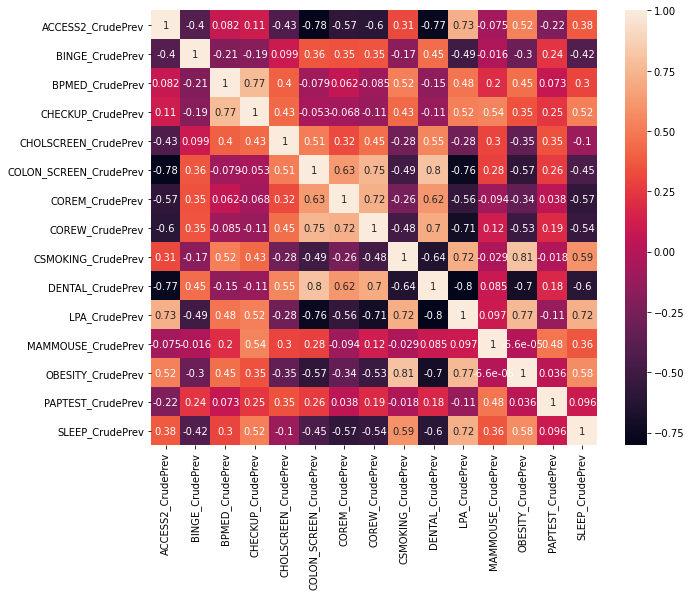

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Correlation matrix plot,color follows heat map, yellow is 1.
corr=df_new3[['ACCESS2_CrudePrev', 'BINGE_CrudePrev', 'BPMED_CrudePrev',
       'CHECKUP_CrudePrev', 'CHOLSCREEN_CrudePrev', 'COLON_SCREEN_CrudePrev',
       'COREM_CrudePrev', 'COREW_CrudePrev', 'CSMOKING_CrudePrev',
       'DENTAL_CrudePrev', 'LPA_CrudePrev', 'MAMMOUSE_CrudePrev',
       'OBESITY_CrudePrev', 'PAPTEST_CrudePrev', 'SLEEP_CrudePrev']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True)
#Many variables are highly correlated. Access2 is highly correlated with colon screen

In [ ]:
#Descriptive stats
df_new3[['ACCESS2_CrudePrev', 'BINGE_CrudePrev', 'BPMED_CrudePrev',
       'CHECKUP_CrudePrev', 'CHOLSCREEN_CrudePrev', 'COLON_SCREEN_CrudePrev',
       'COREM_CrudePrev', 'COREW_CrudePrev', 'CSMOKING_CrudePrev',
       'DENTAL_CrudePrev', 'LPA_CrudePrev', 'MAMMOUSE_CrudePrev',
       'OBESITY_CrudePrev', 'PAPTEST_CrudePrev', 'SLEEP_CrudePrev']].describe()


ACCESS2_CrudePrev  BINGE_CrudePrev  ...  PAPTEST_CrudePrev  SLEEP_CrudePrev
count         500.000000       500.000000  ...         500.000000       500.000000
mean            0.284187         0.467552  ...           0.641739         0.439500
std             0.158302         0.146686  ...           0.143145         0.167052
min             0.000000         0.000000  ...           0.000000         0.000000
25%             0.174242         0.377049  ...           0.564935         0.324219
50%             0.250000         0.461749  ...           0.641739         0.427734
75%             0.366162         0.551913  ...           0.740260         0.542969
max             1.000000         1.000000  ...           1.000000         1.000000

[8 rows x 15 columns]

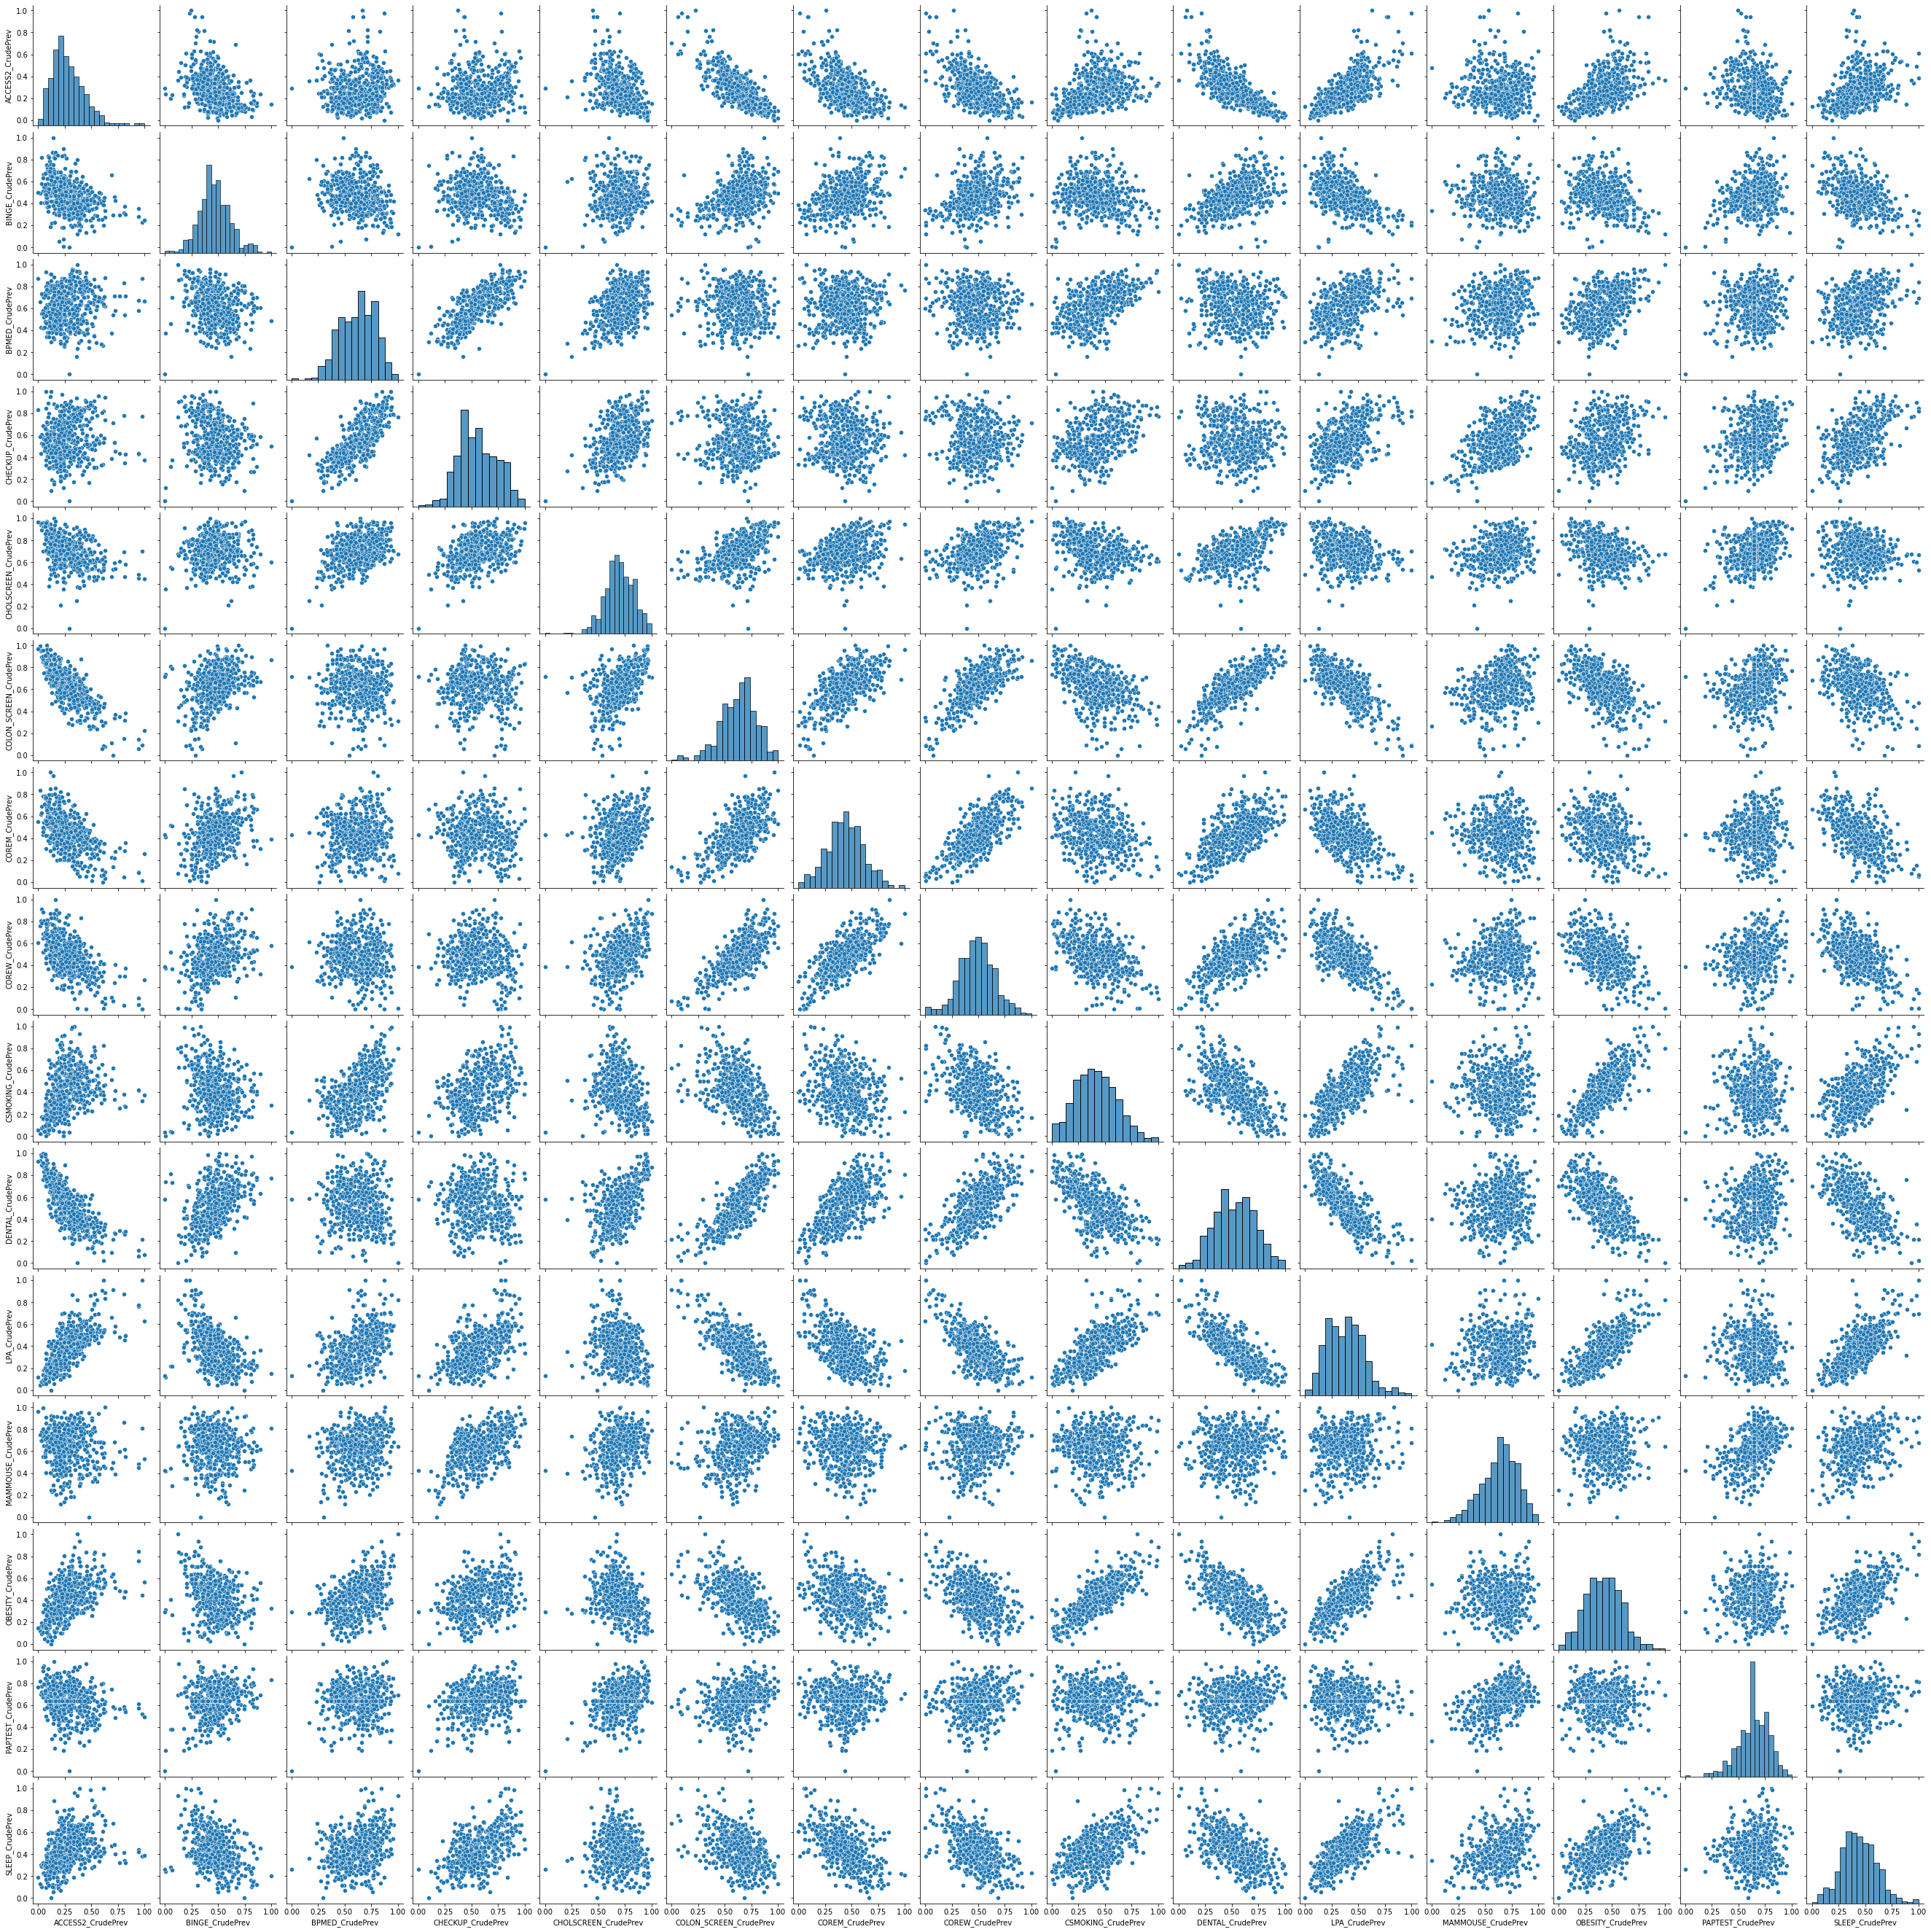

In [ ]:
## Pairplot
dataset = df_new3[['ACCESS2_CrudePrev', 'BINGE_CrudePrev', 'BPMED_CrudePrev',
       'CHECKUP_CrudePrev', 'CHOLSCREEN_CrudePrev', 'COLON_SCREEN_CrudePrev',
       'COREM_CrudePrev', 'COREW_CrudePrev', 'CSMOKING_CrudePrev',
       'DENTAL_CrudePrev', 'LPA_CrudePrev', 'MAMMOUSE_CrudePrev',
       'OBESITY_CrudePrev', 'PAPTEST_CrudePrev', 'SLEEP_CrudePrev']]
g = sns.pairplot(dataset)

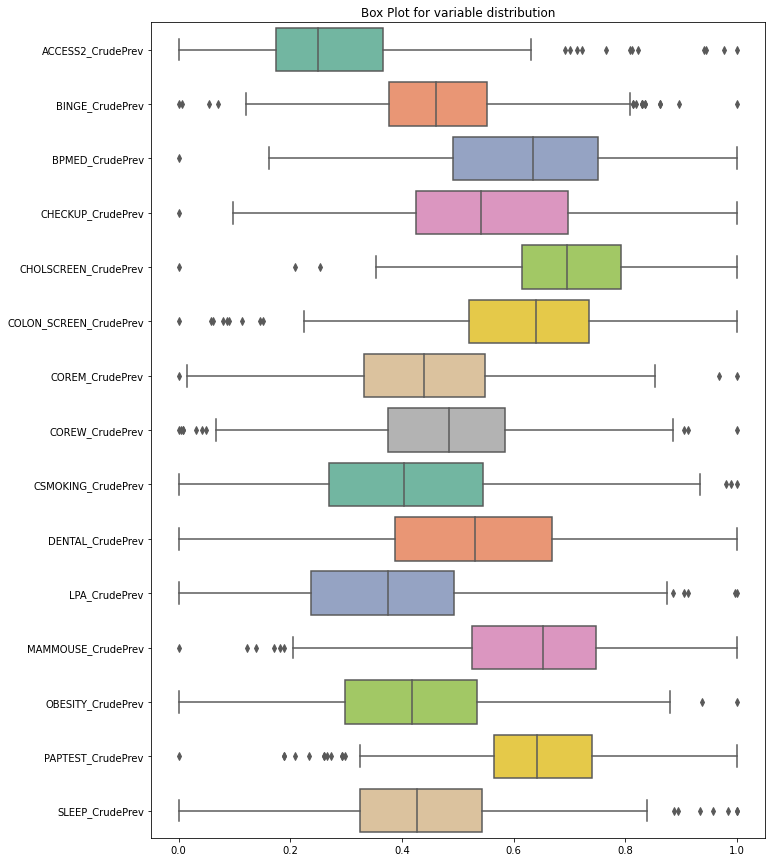

In [ ]:
#Boxplot
f, ax = plt.subplots(figsize=(11, 15))

plt.title("Box Plot for variable distribution")
ax.set(xlim=(-.05, 1.05))
ax = sns.boxplot(data = dataset, 
  orient = 'h', 
  palette = 'Set2')

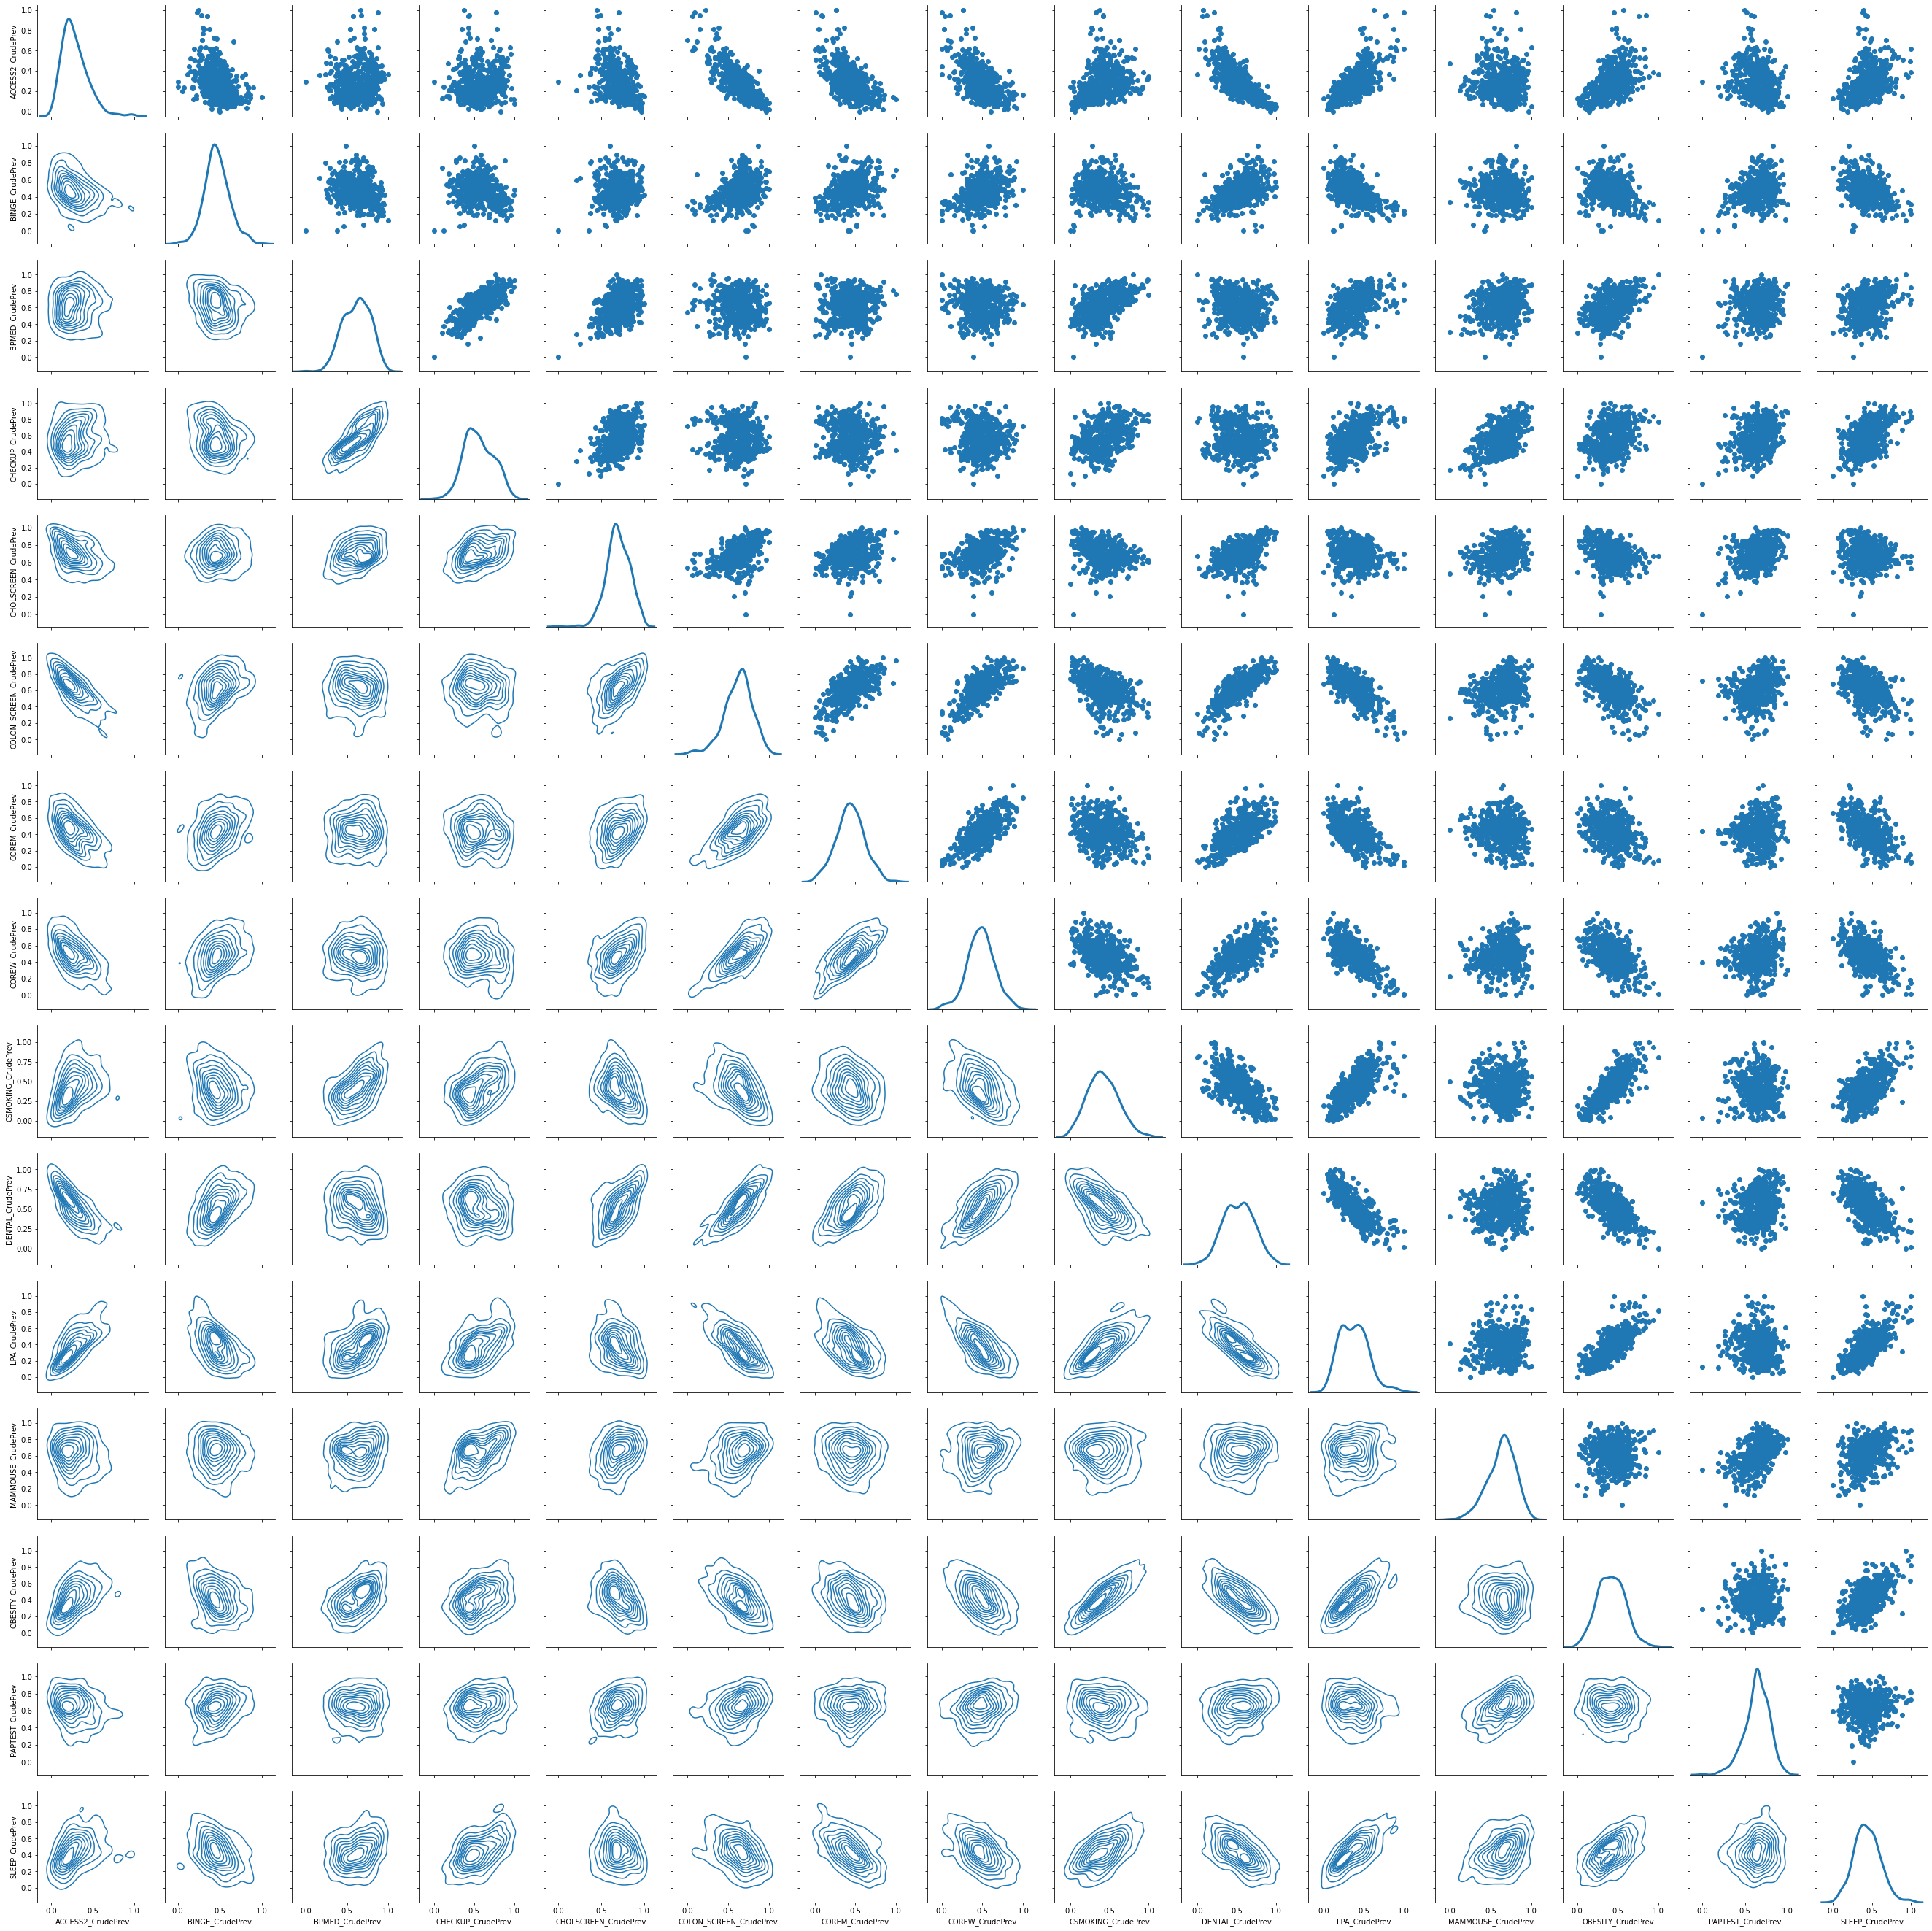

In [ ]:
gi = sns.PairGrid(dataset)
gi.map_upper(plt.scatter)
gi.map_lower(sns.kdeplot)
gi.map_diag(sns.kdeplot, lw=3, legend=False);

## Feature Engineering

In [ ]:
#Interactive terms
#1. LPA and Obesity might have some interaction with each other since LPA is one of the reason lead to obesity especially when 
#other lifestyles do not lead to obesity such as healthy diet.
df_new3['LPAandOBESITY']=df_new3['LPA_CrudePrev']*df_new3['OBESITY_CrudePrev']

#2. CoreM and CoreW might have some interaction with each other. Suppose each variable has a similar relationship with the target,
#the interactive term can have  more information gathered based on genders.
df_new3['Core']=df_new3['COREM_CrudePrev']*df_new3['COREW_CrudePrev']

#Risk score
#Each of these variables may have different scale of impact on the outcome variable. Since our target is cancer, we are going to
#give a higher risk score for CSMOKING_CrudePrev by take the square of it.
df_new3['CSMOKING_Square']=df_new3['CSMOKING_CrudePrev']**2

## Data Preparation

In [ ]:
import random
random.seed(123)

In [ ]:
from sklearn.utils import shuffle
df_new3 = shuffle(df_new3)
df_new3.head()

StateAbbr   PlaceName  PlaceFIPS  ...  LPAandOBESITY      Core  CSMOKING_Square
272        MA  Fall River    2523000  ...       0.256426  0.071277         0.777071
38         CA   San Diego     666000  ...       0.028499  0.173234         0.035938
146        CA  Long Beach     643000  ...       0.095527  0.181757         0.070439
67         PA     Reading    4263624  ...       0.597184  0.062011         0.546618
40         IN      Carmel    1810342  ...       0.043023  0.502963         0.024460

[5 rows x 35 columns]

In [ ]:
#Leave out the 10% test partition
df_model=df_new3.sample(frac=0.9)
df_test=df_new3.drop(df_model.index,axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
feature_cols=['ACCESS2_CrudePrev', 'BINGE_CrudePrev', 'BPMED_CrudePrev',
       'CHECKUP_CrudePrev', 'CHOLSCREEN_CrudePrev', 'COLON_SCREEN_CrudePrev',
       'COREM_CrudePrev', 'COREW_CrudePrev', 'CSMOKING_CrudePrev',
       'DENTAL_CrudePrev', 'LPA_CrudePrev', 'MAMMOUSE_CrudePrev',
       'OBESITY_CrudePrev', 'PAPTEST_CrudePrev', 'SLEEP_CrudePrev','LPAandOBESITY','Core','CSMOKING_Square']
X=df_model[feature_cols].values
y=df_model['CANCER_CrudePrev'].values

X_test=df_test[feature_cols].values
y_test=df_test['CANCER_CrudePrev'].values

#Use the 90% of data for training and validation, then split them with training 80% and validation 10% of the dataset
val_size=len(df_new3)*0.1/len(df_model) #10% of the data is val_size of the training and validation partition
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=123)

## Model Fitting

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Model 0: Baseline model

In [ ]:
from sklearn.dummy import DummyRegressor
#Create Dummy Regression Always Predicts The Mean Value Of Target
base = DummyRegressor(strategy='mean')
model0=base.fit(X_train, y_train)
y_train0=model0.predict(X_train)
y_val0=model0.predict(X_val)
y_test0=model0.predict(X_test)

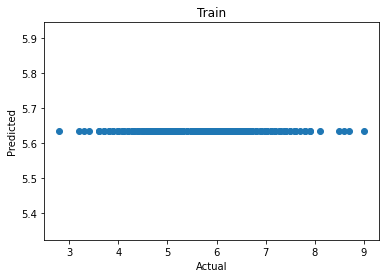

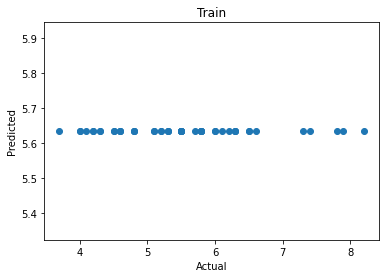

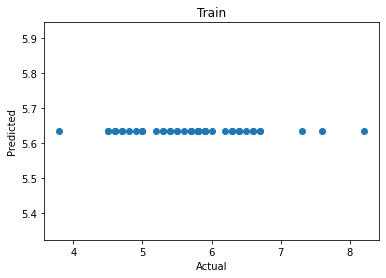

In [ ]:
#Scaltter plots
#train
plt.scatter(y_train,y_train0)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#Validation
plt.scatter(y_val,y_val0)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#Test
plt.scatter(y_test,y_test0)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [ ]:
  
#Error matrics calculation
#train
mae_train=mean_absolute_error(y_train, y_train0)
mape_train=mean_absolute_percentage_error(y_train, y_train0)
rmse_train=sqrt(mean_squared_error(y_train, y_train0))
sd_train=np.std(abs(y_train-y_train0))
bias_train=np.mean(y_train0-y_train)
#Validation
mae_val=mean_absolute_error(y_val, y_val0)
mape_val=mean_absolute_percentage_error(y_val, y_val0)
rmse_val=sqrt(mean_squared_error(y_val, y_val0))
sd_val=np.std(abs(y_val-y_val0))
bias_val=np.mean(y_val0-y_val)
#Test
mae_test=mean_absolute_error(y_test, y_test0)
mape_test=mean_absolute_percentage_error(y_test, y_test0)
rmse_test=sqrt(mean_squared_error(y_test, y_test0))
sd_test=np.std(abs(y_test-y_test0))
bias_test=np.mean(y_test0-y_test)

train=[mae_train,mape_train,rmse_train,sd_train,bias_train]
val=[mae_val,mape_val,rmse_val,sd_val,bias_val]
test=[mae_test,mape_test,rmse_test,sd_test,bias_test]

e_metrics=[train,val,test]

table=pd.DataFrame(e_metrics,columns =['MAE','MAPE','RMSE','SD(AE)','BIAS'])
table['index']=['Train','Validate','Test']
table.set_index('index',inplace=True)
table

MAE       MAPE      RMSE    SD(AE)          BIAS
index                                                         
Train     0.78614  14.593724  0.990514  0.602579  3.907985e-16
Validate  0.83356  15.898244  1.052484  0.642574  1.227500e-01
Test      0.65105  11.547776  0.844094  0.537242 -9.925000e-02

In [ ]:
#No variable importance for baseline model since we are taking the simple average of the target.

In [ ]:
#No partial dependence for baseline model since we are taking the simple average of the target.

### Model 1: Random forest

In [ ]:
scoring='neg_mean_squared_error'
#Take the range from 10 to 100 step by 10 as the number of estimators since we do not want only a few or too many to avoid
#underfitting or overfitting.
param_grid = dict(n_estimators=np.array([10,20,30,40,50,60,70,80,90,100]))
model = RandomForestRegressor(random_state=123)
kfold = KFold(n_splits=10, random_state=123)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

model1=model.fit(X_train,y_train)
y_train1=model1.predict(X_train)
y_val1=model1.predict(X_val)
y_test1=model1.predict(X_test)

#Result shows that number of estimators equals to 70 gives the best result as a negative mean square error of -0.3029.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best: -0.310307 using {'n_estimators': 40}
-0.336304 (0.057826) with: {'n_estimators': 10}
-0.318294 (0.050871) with: {'n_estimators': 20}
-0.314154 (0.054180) with: {'n_estimators': 30}
-0.310307 (0.050358) with: {'n_estimators': 40}
-0.313473 (0.049609) with: {'n_estimators': 50}
-0.314012 (0.047164) with: {'n_estimators': 60}
-0.318150 (0.048268) with: {'n_estimators': 70}
-0.319390 (0.046395) with: {'n_estimators': 80}
-0.319947 (0.047333) with: {'n_estimators': 90}
-0.320876 (0.047840) with: {'n_estimators': 100}


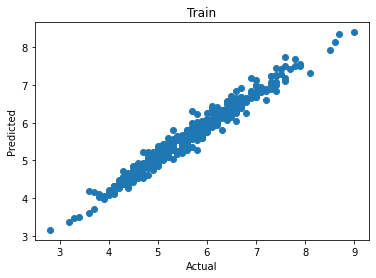

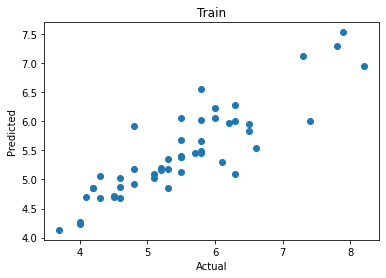

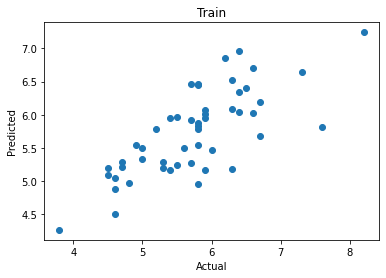

In [ ]:
#Scaltter plots
#train
plt.scatter(y_train,y_train1)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#Validation
plt.scatter(y_val,y_val1)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#Test
plt.scatter(y_test,y_test1)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [ ]:
#Error matrics calculation
#train
mae_train=mean_absolute_error(y_train, y_train1)
mape_train=mean_absolute_percentage_error(y_train, y_train1)
rmse_train=sqrt(mean_squared_error(y_train, y_train1))
sd_train=np.std(abs(y_train-y_train1))
bias_train=np.mean(y_train1-y_train)
#Validation
mae_val=mean_absolute_error(y_val, y_val1)
mape_val=mean_absolute_percentage_error(y_val, y_val1)
rmse_val=sqrt(mean_squared_error(y_val, y_val1))
sd_val=np.std(abs(y_val-y_val1))
bias_val=np.mean(y_val1-y_val)
#Test
mae_test=mean_absolute_error(y_test, y_test1)
mape_test=mean_absolute_percentage_error(y_test, y_test1)
rmse_test=sqrt(mean_squared_error(y_test, y_test1))
sd_test=np.std(abs(y_test-y_test1))
bias_test=np.mean(y_test1-y_test)

train=[mae_train,mape_train,rmse_train,sd_train,bias_train]
val=[mae_val,mape_val,rmse_val,sd_val,bias_val]
test=[mae_test,mape_test,rmse_test,sd_test,bias_test]

e_metrics=[train,val,test]

table=pd.DataFrame(e_metrics,columns =['MAE','MAPE','RMSE','SD(AE)','BIAS'])
table['index']=['Train','Validate','Test']
table.set_index('index',inplace=True)
table

MAE      MAPE      RMSE    SD(AE)      BIAS
index                                                     
Train     0.161498  2.909331  0.207262  0.129909  0.004833
Validate  0.395900  7.191302  0.524805  0.344504 -0.040940
Test      0.442140  7.674481  0.556848  0.338514  0.002740

---------------------
These are the importances...
[0.10166873 0.02153944 0.34339229 0.02883335 0.21168307 0.02724437
 0.02374276 0.01233929 0.01589462 0.01540838 0.01536504 0.03791441
 0.02006029 0.02857985 0.04841518 0.00999283 0.02310699 0.0148191 ]
---------------------
    StateAbbr      PlaceName  ...      Core  CSMOKING_Square
159        IA       Waterloo  ...  0.577957         0.276746
287        CO         Aurora  ...  0.265518         0.224613
461        AR    Little Rock  ...  0.340268         0.286808
126        CA  Newport Beach  ...  0.637769         0.000359
120        IL         Aurora  ...  0.104370         0.211338

[5 rows x 35 columns]


([<matplotlib.axis.XTick at 0x7fa3e0c52908>,
 [Text(0, 0, 'BPMED_CrudePrev'),
  Text(0, 0, 'CHOLSCREEN_CrudePrev'),
  Text(0, 0, 'ACCESS2_CrudePrev'),
  Text(0, 0, 'SLEEP_CrudePrev'),
  Text(0, 0, 'MAMMOUSE_CrudePrev'),
  Text(0, 0, 'CHECKUP_CrudePrev'),
  Text(0, 0, 'PAPTEST_CrudePrev'),
  Text(0, 0, 'COLON_SCREEN_CrudePrev'),
  Text(0, 0, 'COREM_CrudePrev'),
  Text(0, 0, 'Core'),
  Text(0, 0, 'BINGE_CrudePrev'),
  Text(0, 0, 'OBESITY_CrudePrev'),
  Text(0, 0, 'CSMOKING_CrudePrev'),
  Text(0, 0, 'DENTAL_CrudePrev'),
  Text(0, 0, 'LPA_CrudePrev'),
  Text(0, 0, 'CSMOKING_Square'),
  Text(0, 0, 'COREW_CrudePrev'),
  Text(0, 0, 'LPAandOBESITY')])

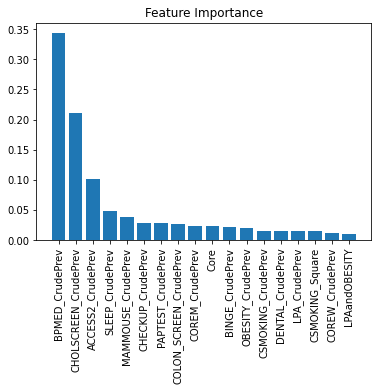

In [ ]:
#Variable importance
importances = model1.feature_importances_

# let's add a print statement to see what's going on
print("---------------------")
print("These are the importances...")
print(importances)
print("---------------------")
print(pd.DataFrame.head(df_model))
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
X_plt=df_model[feature_cols]
names = [X_plt.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_plt.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_plt.shape[1]), names, rotation=90)

In [ ]:
pip install pdpbox

     |████████████████████████████████| 57.7MB 75kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=8c8c14aef049735fd11a7026d49cc6c636e70db4713b7e6961fea79450e0a2e2
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


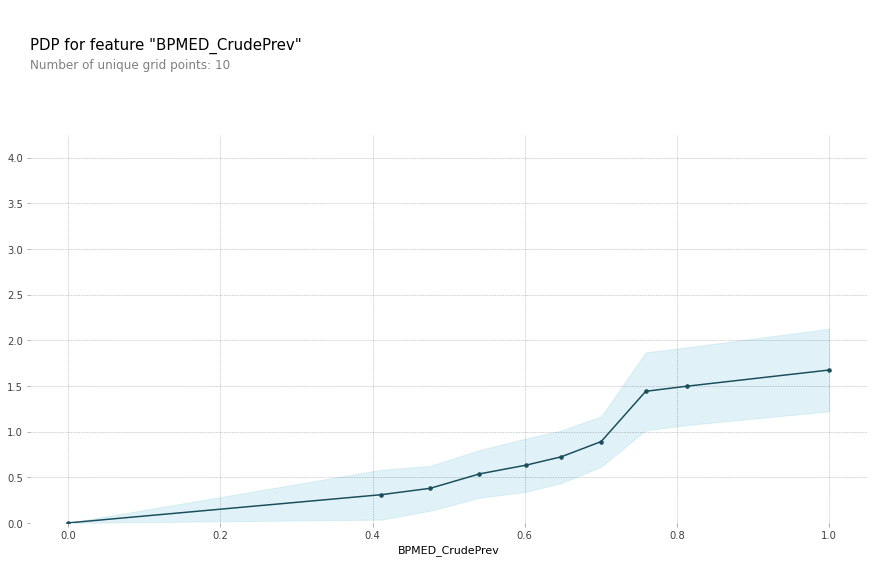

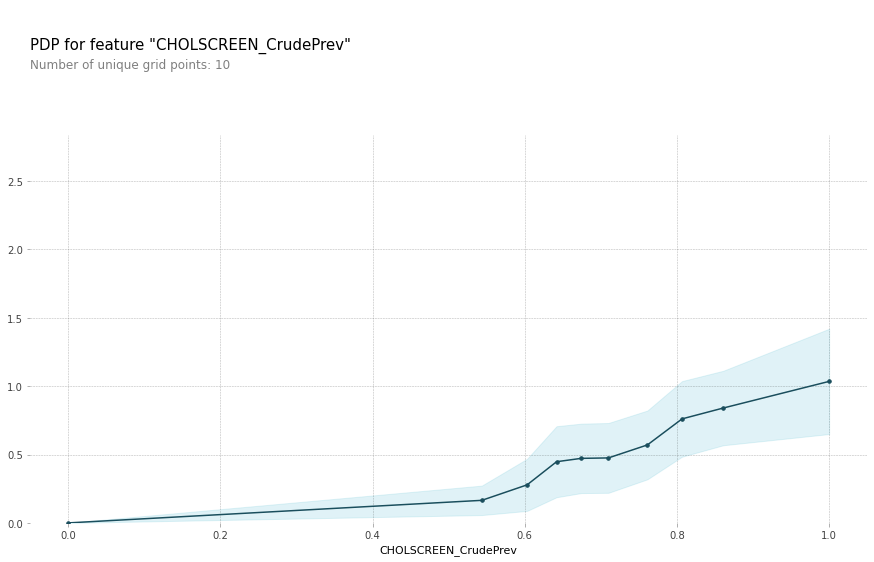

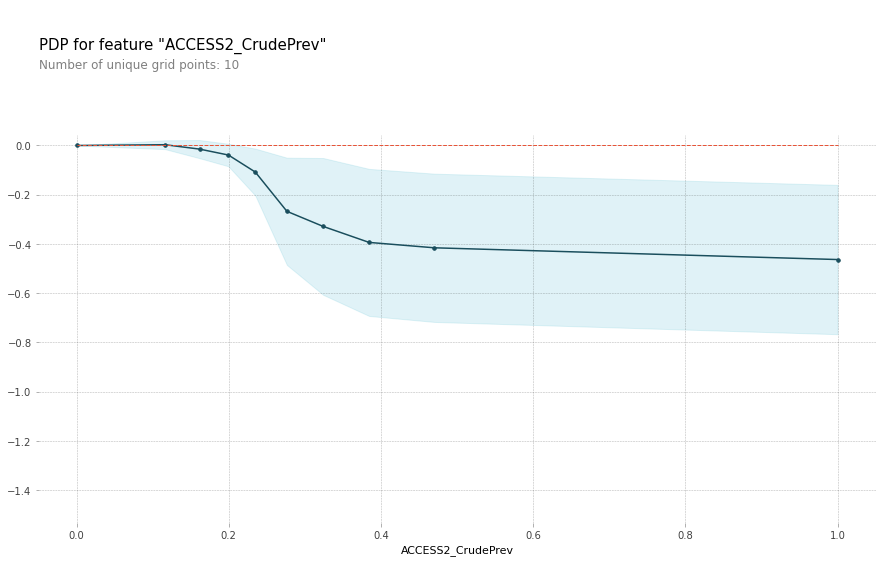

In [ ]:
#My top 3 important variables are BPMED, CHOLSCREEN and ACCESS2
#Partial dependency
data=pd.concat([df_model[feature_cols],df_model['CANCER_CrudePrev']],axis=1)
from pdpbox import pdp, get_dataset, info_plots
pdp11 = pdp.pdp_isolate(
    model=model1, dataset=data, model_features=feature_cols, feature='BPMED_CrudePrev')
fig, axes = pdp.pdp_plot(pdp11, 'BPMED_CrudePrev')
plt.show()
pdp12 = pdp.pdp_isolate(
    model=model1, dataset=data, model_features=feature_cols, feature='CHOLSCREEN_CrudePrev')
fig, axes = pdp.pdp_plot(pdp12, 'CHOLSCREEN_CrudePrev')
plt.show()
pdp13 = pdp.pdp_isolate(
    model=model1, dataset=data, model_features=feature_cols, feature='ACCESS2_CrudePrev')
fig, axes = pdp.pdp_plot(pdp13, 'ACCESS2_CrudePrev')
plt.show()

#Taking medicine for high blood pressure control and Cholesterol screen possitively affect having cancer, while
#having insurance negatively affect having cancer. And larger the scale of the feature, faster of the trend.

### Model2: GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor(random_state=123)
kfold = KFold(n_splits=10, random_state=123)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

model2=model.fit(X_train,y_train)
y_train2=model2.predict(X_train)
y_val2=model2.predict(X_val)
y_test2=model2.predict(X_test)

#Result shows that number of estimators equals to 200 gives the best result as a negative mean square error of -0.2786.

Best: -0.288976 using {'n_estimators': 200}
-0.323154 (0.053572) with: {'n_estimators': 50}
-0.295844 (0.056666) with: {'n_estimators': 100}
-0.290946 (0.061211) with: {'n_estimators': 150}
-0.288976 (0.061229) with: {'n_estimators': 200}
-0.289410 (0.060615) with: {'n_estimators': 250}
-0.289988 (0.059272) with: {'n_estimators': 300}
-0.289667 (0.059342) with: {'n_estimators': 350}
-0.290019 (0.058820) with: {'n_estimators': 400}


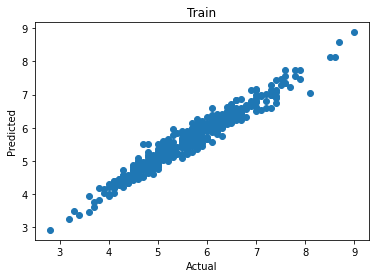

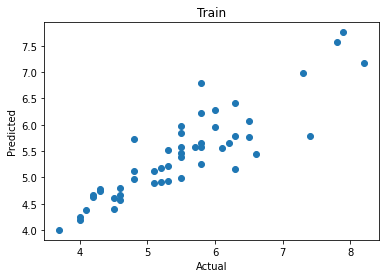

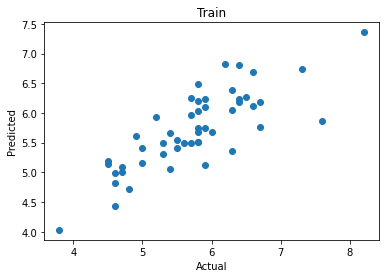

In [ ]:
#Scaltter plots
#train
plt.scatter(y_train,y_train2)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#Validation
plt.scatter(y_val,y_val2)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#Test
plt.scatter(y_test,y_test2)
plt.title('Train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [ ]:
#Error matrics calculation
#train
mae_train=mean_absolute_error(y_train, y_train2)
mape_train=mean_absolute_percentage_error(y_train, y_train2)
rmse_train=sqrt(mean_squared_error(y_train, y_train2))
sd_train=np.std(abs(y_train-y_train2))
bias_train=np.mean(y_train2-y_train)
#Validation
mae_val=mean_absolute_error(y_val, y_val2)
mape_val=mean_absolute_percentage_error(y_val, y_val2)
rmse_val=sqrt(mean_squared_error(y_val, y_val2))
sd_val=np.std(abs(y_val-y_val2))
bias_val=np.mean(y_val2-y_val)
#Test
mae_test=mean_absolute_error(y_test, y_test2)
mape_test=mean_absolute_percentage_error(y_test, y_test2)
rmse_test=sqrt(mean_squared_error(y_test, y_test2))
sd_test=np.std(abs(y_test-y_test2))
bias_test=np.mean(y_test2-y_test)

train=[mae_train,mape_train,rmse_train,sd_train,bias_train]
val=[mae_val,mape_val,rmse_val,sd_val,bias_val]
test=[mae_test,mape_test,rmse_test,sd_test,bias_test]
e_metrics=[train,val,test]

table2=pd.DataFrame(e_metrics,columns =['MAE','MAPE','RMSE','SD(AE)','BIAS'])
table2['index']=['Train','Validate','Test']
table2.set_index('index',inplace=True)
table2

MAE      MAPE      RMSE    SD(AE)          BIAS
index                                                         
Train     0.183364  3.280415  0.237375  0.150746  4.884981e-17
Validate  0.376268  6.660202  0.506277  0.338732 -7.210384e-02
Test      0.382245  6.580840  0.492095  0.309913 -1.238628e-02

---------------------
These are the importances...
[0.12639896 0.01039333 0.38209172 0.02754205 0.21138566 0.01420486
 0.01359173 0.00218366 0.01597732 0.00904597 0.0160431  0.06356433
 0.01732191 0.03009759 0.03159956 0.00459584 0.00824331 0.01571911]
---------------------
    StateAbbr      PlaceName  ...      Core  CSMOKING_Square
159        IA       Waterloo  ...  0.577957         0.276746
287        CO         Aurora  ...  0.265518         0.224613
461        AR    Little Rock  ...  0.340268         0.286808
126        CA  Newport Beach  ...  0.637769         0.000359
120        IL         Aurora  ...  0.104370         0.211338

[5 rows x 35 columns]


([<matplotlib.axis.XTick at 0x7fa3decd40f0>,
 [Text(0, 0, 'BPMED_CrudePrev'),
  Text(0, 0, 'CHOLSCREEN_CrudePrev'),
  Text(0, 0, 'ACCESS2_CrudePrev'),
  Text(0, 0, 'MAMMOUSE_CrudePrev'),
  Text(0, 0, 'SLEEP_CrudePrev'),
  Text(0, 0, 'PAPTEST_CrudePrev'),
  Text(0, 0, 'CHECKUP_CrudePrev'),
  Text(0, 0, 'OBESITY_CrudePrev'),
  Text(0, 0, 'LPA_CrudePrev'),
  Text(0, 0, 'CSMOKING_CrudePrev'),
  Text(0, 0, 'CSMOKING_Square'),
  Text(0, 0, 'COLON_SCREEN_CrudePrev'),
  Text(0, 0, 'COREM_CrudePrev'),
  Text(0, 0, 'BINGE_CrudePrev'),
  Text(0, 0, 'DENTAL_CrudePrev'),
  Text(0, 0, 'Core'),
  Text(0, 0, 'LPAandOBESITY'),
  Text(0, 0, 'COREW_CrudePrev')])

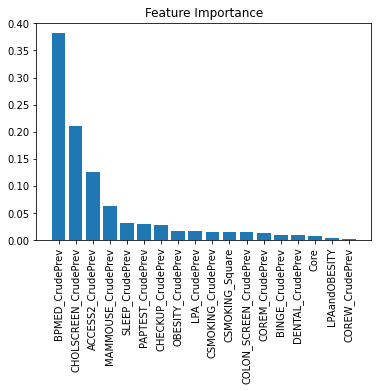

In [ ]:
#Variable importance
importances = model2.feature_importances_

# let's add a print statement to see what's going on
print("---------------------")
print("These are the importances...")
print(importances)
print("---------------------")
print(pd.DataFrame.head(df_model))
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
X_plt=df_model[feature_cols]
names = [X_plt.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_plt.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_plt.shape[1]), names, rotation=90)

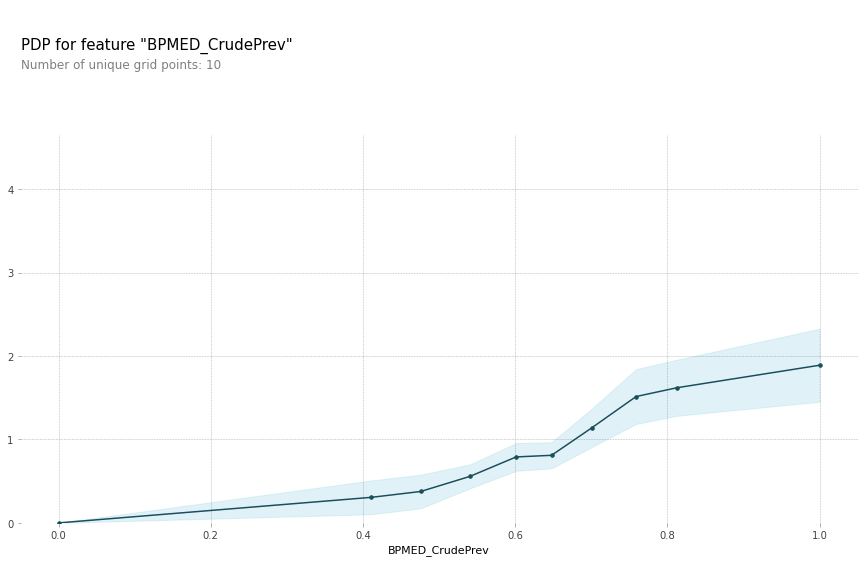

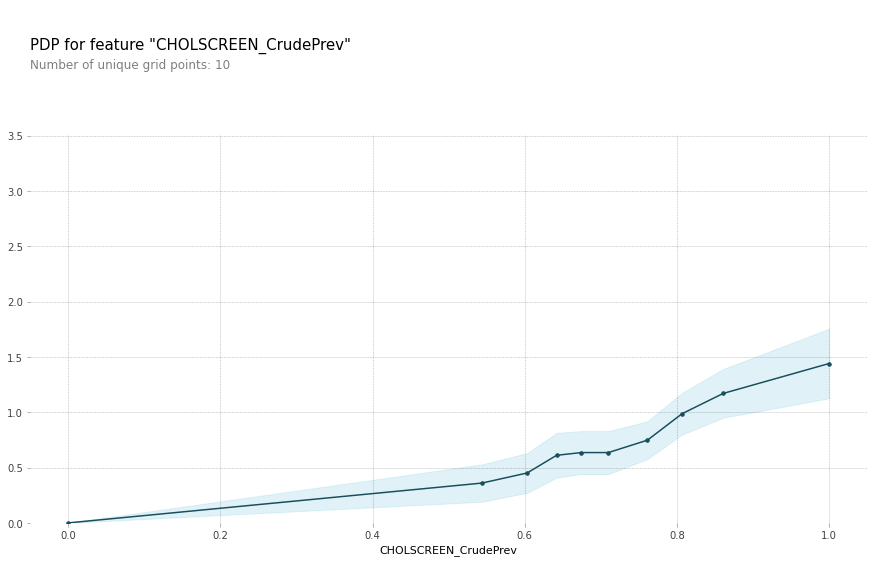

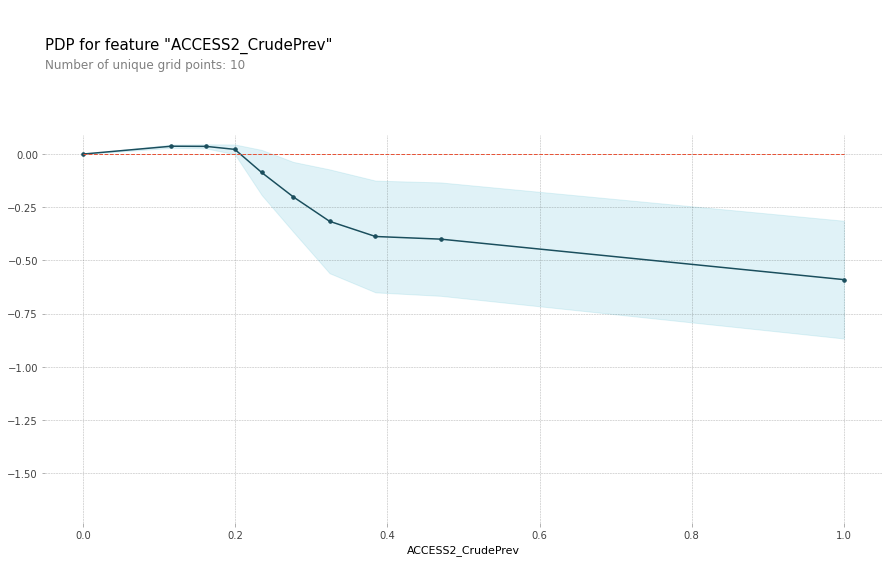

In [ ]:
#My top 3 important variables are BPMED, CHOLSCREEN and ACCESS2
#Partial dependency
data=pd.concat([df_model[feature_cols],df_model['CANCER_CrudePrev']],axis=1)
from pdpbox import pdp, get_dataset, info_plots
pdp11 = pdp.pdp_isolate(
    model=model2, dataset=data, model_features=feature_cols, feature='BPMED_CrudePrev')
fig, axes = pdp.pdp_plot(pdp11, 'BPMED_CrudePrev')
plt.show()
pdp12 = pdp.pdp_isolate(
    model=model2, dataset=data, model_features=feature_cols, feature='CHOLSCREEN_CrudePrev')
fig, axes = pdp.pdp_plot(pdp12, 'CHOLSCREEN_CrudePrev')
plt.show()
pdp13 = pdp.pdp_isolate(
    model=model2, dataset=data, model_features=feature_cols, feature='ACCESS2_CrudePrev')
fig, axes = pdp.pdp_plot(pdp13, 'ACCESS2_CrudePrev')
plt.show()